In [1]:
# Version: 0.0.1
# Date:    2022-07-22
# Author:  P. J. Vetter, Timo Joas
# Email=  philipp.vetter@uni-ulm.de;

In [1]:
# Simulation to investigate the robustness of the optimal control pulse. 
# Pulse units are abstracted away by imported ArbPulse class

# The oc_element function reads in the pulse files and creates the corresponding pulse

# all possible initial states are defined in the 'Initial State' section
# density matrix of the m_s = 0 state: rho_ms0 
# density matrix of the m_s = -1 state: rho_msm1
# density matrix of the x state: rho_x
# density matrix of the y state: rho_y

# (The first run might take a bit longer due to the plot generation)

# Packages

In [1]:
import os
os.getcwd()

'C:\\Software\\qudi\\user_scripts\\Timo\\own\\optimalcontrol'

In [45]:
#%matplotlib notebook
#%matplotlib notebook

import qutip
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
from scipy import interpolate
import matplotlib as mpl

from oc_simlib import TimeDependentSimulation, SimParameters, ArbPulse, PredefinedArbPulses

plt.rcParams.update({'font.size': 30})  

# Library

In [3]:
def get_f_limits(f_res, f_center_block, df, symm_block=False):
    f_center_block_mhz = f_center_block*1e-6
    f_res_mhz = f_res*1e-6
    df_mhz = df*1e-6
    freqs = []
    if symm_block:
        delta_block = f_center_block_mhz - f_res_mhz
        f_center_2_mhz = f_res_mhz - delta_block
        f_centers = [f_center_block_mhz, f_center_2_mhz]
    else:
        f_centers = [f_center_block_mhz]
    for f in f_centers:
        freqs.append([1e6*(f-df_mhz), 1e6*(f+df_mhz)])
    return freqs
    
def calc_crosstalk_penalty(freqs, spin_pop, f_res, f_center_block, df, symm_block=False, fac_penalty=1):

    
    idxs = np.empty((0), dtype=int)
    for (f_min, f_max) in get_f_limits(f_res, f_center_block, df, symm_block=symm_block):      
        idxs = np.append(idxs, np.where(np.logical_and(freqs >= f_min, freqs <= f_max)))
    
    #return idxs
    spin_pop = np.mean(spin_pop[idxs])
    
    # as in optimalcontrol_quocs.ipynb
    fom_sim = (1 + fac_penalty*(abs(1-spin_pop)))
    
    return fom_sim

# Variables

In [4]:
# magnetic field [G]
B = 90

## Load pulses

In [48]:



folder = r"input_pulses\rect"
name = "rec_amp_20MHz_0.025mus_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='µs', unit_data='MHz')

#folder = r"input_pulses"
#name = "on_nv=2_"

folder = r"C:\Software\qudi_data\optimal_control_assets\20220727_1_guessFromReisserMsc"
name = "opt_res_"
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.24*20,
                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.24*20))

folder = r"C:\Software\qudi_data\optimal_control_assets\20220729_1_guessFromReisserMsc_penalty_fac=100"
name = "opt_res_"
name = "opt_res_"
pulse = ArbPulse.load_pulse(folder, name, unit_t='s', unit_data='V',
                            func_ampl_v_2_omega_mhz=lambda x: x/0.24*20,
                            func_omega_mhz_2_ampl_v=lambda x: 1/(x/0.24*20))

#folder = r"C:\Software\qudi_data\optimal_control_assets\Reisser_MSc_pulse_1"
#name = "Opt_Pulse_01_"
#pulse = ArbPulse.load_pulse(folder, name, unit_t='ns', unit_data='MHz')


# loading experimental pulse
# 0.25 = 20 MHz
#pulse = ArbPulse.load_pulse(folder, name, unit_t='s',  func_ampl_v_2_omega_mhz=lambda x: x/0.25*20)


#pulse = TimeDependentSimulation.load_pulse(folder, name, func_t_2_us=lambda t: t*1e6)
#
pulse.as_dict()




{'name': 'opt_res_',
 'folder': 'C:\\Software\\qudi_data\\optimal_control_assets\\20220729_1_guessFromReisserMsc_penalty_fac=100',
 'file': ['C:\\Software\\qudi_data\\optimal_control_assets\\20220729_1_guessFromReisserMsc_penalty_fac=100\\opt_res_amplitude.txt',
  'C:\\Software\\qudi_data\\optimal_control_assets\\20220729_1_guessFromReisserMsc_penalty_fac=100\\opt_res_phase.txt'],
 'timegrid_unit': 's',
 'data_unit': 'V',
 'data_ampl': array([0.06375583, 0.06320136, 0.06265724, ..., 0.00184427, 0.00131669,
        0.00078812]),
 'data_phase': array([ 0.01591353,  0.01633561,  0.01675244, ..., -0.00459714,
        -0.00486251, -0.00513258]),
 'timegrid_ampl': array([0.00000000e+00, 5.00250125e-11, 1.00050025e-10, ...,
        9.98999500e-08, 9.99499750e-08, 1.00000000e-07]),
 'timegrid_phase': array([0.00000000e+00, 5.00250125e-11, 1.00050025e-10, ...,
        9.98999500e-08, 9.99499750e-08, 1.00000000e-07])}

In [19]:
pulse.as_dict()

{'name': 'opt_res_',
 'folder': 'C:\\Software\\qudi_data\\optimal_control_assets\\20220729_1_guessFromReisserMsc_penalty_fac=100',
 'file': ['C:\\Software\\qudi_data\\optimal_control_assets\\20220729_1_guessFromReisserMsc_penalty_fac=100\\opt_res_amplitude.txt',
  'C:\\Software\\qudi_data\\optimal_control_assets\\20220729_1_guessFromReisserMsc_penalty_fac=100\\opt_res_phase.txt'],
 'timegrid_unit': 's',
 'data_unit': 'V',
 'data_ampl': array([0.06375583, 0.06320136, 0.06265724, ..., 0.00184427, 0.00131669,
        0.00078812]),
 'data_phase': array([ 0.01591353,  0.01633561,  0.01675244, ..., -0.00459714,
        -0.00486251, -0.00513258]),
 'timegrid_ampl': array([0.00000000e+00, 5.00250125e-11, 1.00050025e-10, ...,
        9.98999500e-08, 9.99499750e-08, 1.00000000e-07]),
 'timegrid_phase': array([0.00000000e+00, 5.00250125e-11, 1.00050025e-10, ...,
        9.98999500e-08, 9.99499750e-08, 1.00000000e-07])}

In [7]:
len(pulse.as_dict()['timegrid_ampl'])

2000

## Generate pulses

In [4]:

pulse = PredefinedArbPulses.generate_levitt(20e6, phase=0)
#pulse = PredefinedArbPulses.generate_rect_pi(20e6, phase=0)

#pulse['data_phase']
#val_i, val_q = np.asarray([1,0])*1
#np.asarray([np.pi/2, 0, np.pi/2]) + 0

#data_ampl = np.asarray([0,0,0])
#data_ampl[0:3] = 1
#data_ampl

## Plot pulses

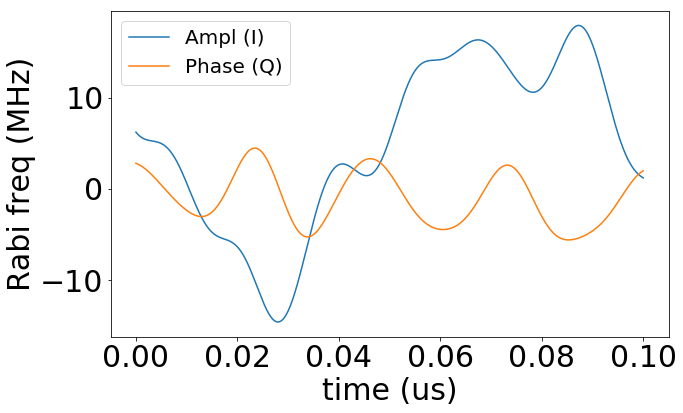

In [46]:
import matplotlib.pyplot as plt
    
t_amplitude = pulse.get_timegrid(unit='µs')
amplitude = pulse.get_data_ampl(unit='MHz')
t_phase = pulse.get_timegrid(unit='µs')
phase = pulse.get_data_phase(unit='MHz')

try:
    plt.figure(figsize=(10,6))
    plt.plot(t_amplitude, amplitude, label="Ampl (I)")
    plt.plot(t_phase, phase, label="Phase (Q)")
   # plt.plot(t_phase, phase+amplitude, label="I+Q")
    plt.ylabel("Rabi freq (MHz)")
    plt.xlabel("time (us)")
    plt.legend(loc='best', prop={'size': 20})
    plt.show()
except:
    logger.exception("")

# Parameters, Operators

In [21]:

simp = SimParameters()
simp.gamma_nv

2.8

# Measurements

In [7]:
exp_data = np.asarray([[2.58500000e+09, 2.58600000e+09, 2.58700000e+09, 2.58800000e+09,
        2.58900000e+09, 2.59000000e+09, 2.59100000e+09, 2.59200000e+09,
        2.59300000e+09, 2.59400000e+09, 2.59500000e+09, 2.59600000e+09,
        2.59700000e+09, 2.59800000e+09, 2.59900000e+09, 2.60000000e+09,
        2.60100000e+09, 2.60200000e+09, 2.60300000e+09, 2.60400000e+09,
        2.60500000e+09, 2.60600000e+09, 2.60700000e+09, 2.60800000e+09,
        2.60900000e+09, 2.61000000e+09, 2.61100000e+09, 2.61200000e+09,
        2.61300000e+09, 2.61400000e+09, 2.61500000e+09, 2.61600000e+09,
        2.61700000e+09, 2.61800000e+09, 2.61900000e+09, 2.62000000e+09,
        2.62100000e+09, 2.62200000e+09, 2.62300000e+09, 2.62400000e+09,
        2.62500000e+09, 2.62600000e+09, 2.62700000e+09, 2.62800000e+09,
        2.62900000e+09, 2.63000000e+09, 2.63100000e+09, 2.63200000e+09,
        2.63300000e+09, 2.63400000e+09, 2.63500000e+09, 2.63600000e+09,
        2.63700000e+09, 2.63800000e+09, 2.63900000e+09, 2.64000000e+09,
        2.64100000e+09, 2.64200000e+09, 2.64300000e+09, 2.64400000e+09,
        2.64500000e+09, 2.64600000e+09, 2.64700000e+09, 2.64800000e+09,
        2.64900000e+09, 2.65000000e+09, 2.65100000e+09, 2.65200000e+09,
        2.65300000e+09, 2.65400000e+09, 2.65500000e+09, 2.65600000e+09,
        2.65700000e+09, 2.65800000e+09, 2.65900000e+09, 2.66000000e+09,
        2.66100000e+09, 2.66200000e+09, 2.66300000e+09, 2.66400000e+09,
        2.66500000e+09, 2.66600000e+09, 2.66700000e+09, 2.66800000e+09,
        2.66900000e+09, 2.67000000e+09, 2.67100000e+09, 2.67200000e+09,
        2.67300000e+09, 2.67400000e+09, 2.67500000e+09, 2.67600000e+09,
        2.67700000e+09, 2.67800000e+09, 2.67900000e+09, 2.68000000e+09,
        2.68100000e+09, 2.68200000e+09, 2.68300000e+09, 2.68400000e+09,
        2.68500000e+09, 2.68600000e+09, 2.68700000e+09, 2.68800000e+09,
        2.68900000e+09, 2.69000000e+09, 2.69100000e+09, 2.69200000e+09,
        2.69300000e+09, 2.69400000e+09, 2.69500000e+09, 2.69600000e+09,
        2.69700000e+09, 2.69800000e+09, 2.69900000e+09, 2.70000000e+09,
        2.70100000e+09, 2.70200000e+09, 2.70300000e+09, 2.70400000e+09,
        2.70500000e+09, 2.70600000e+09, 2.70700000e+09, 2.70800000e+09,
        2.70900000e+09, 2.71000000e+09, 2.71100000e+09, 2.71200000e+09,
        2.71300000e+09, 2.71400000e+09, 2.71500000e+09, 2.71600000e+09,
        2.71700000e+09, 2.71800000e+09, 2.71900000e+09, 2.72000000e+09,
        2.72100000e+09, 2.72200000e+09, 2.72300000e+09, 2.72400000e+09,
        2.72500000e+09, 2.72600000e+09, 2.72700000e+09, 2.72800000e+09,
        2.72900000e+09, 2.73000000e+09, 2.73100000e+09, 2.73200000e+09,
        2.73300000e+09, 2.73400000e+09, 2.73500000e+09, 2.73600000e+09,
        2.73700000e+09, 2.73800000e+09, 2.73900000e+09, 2.74000000e+09,
        2.74100000e+09, 2.74200000e+09, 2.74300000e+09, 2.74400000e+09,
        2.74500000e+09, 2.74600000e+09, 2.74700000e+09, 2.74800000e+09,
        2.74900000e+09, 2.75000000e+09, 2.75100000e+09, 2.75200000e+09,
        2.75300000e+09, 2.75400000e+09, 2.75500000e+09, 2.75600000e+09,
        2.75700000e+09, 2.75800000e+09, 2.75900000e+09, 2.76000000e+09,
        2.76100000e+09, 2.76200000e+09, 2.76300000e+09, 2.76400000e+09,
        2.76500000e+09, 2.76600000e+09, 2.76700000e+09, 2.76800000e+09,
        2.76900000e+09, 2.77000000e+09, 2.77100000e+09, 2.77200000e+09,
        2.77300000e+09, 2.77400000e+09, 2.77500000e+09, 2.77600000e+09,
        2.77700000e+09, 2.77800000e+09, 2.77900000e+09, 2.78000000e+09,
        2.78100000e+09, 2.78200000e+09, 2.78300000e+09, 2.78400000e+09,
        2.78500000e+09, 2.78600000e+09, 2.78700000e+09, 2.78800000e+09,
        2.78900000e+09, 2.79000000e+09, 2.79100000e+09, 2.79200000e+09,
        2.79300000e+09, 2.79400000e+09, 2.79500000e+09, 2.79600000e+09,
        2.79700000e+09, 2.79800000e+09, 2.79900000e+09, 2.80000000e+09,
        2.80100000e+09, 2.80200000e+09, 2.80300000e+09, 2.80400000e+09,
        2.80500000e+09, 2.80600000e+09, 2.80700000e+09, 2.80800000e+09,
        2.80900000e+09, 2.81000000e+09, 2.81100000e+09, 2.81200000e+09,
        2.81300000e+09, 2.81400000e+09, 2.81500000e+09, 2.81600000e+09,
        2.81700000e+09, 2.81800000e+09, 2.81900000e+09, 2.82000000e+09,
        2.82100000e+09, 2.82200000e+09, 2.82300000e+09, 2.82400000e+09,
        2.82500000e+09, 2.82600000e+09, 2.82700000e+09, 2.82800000e+09,
        2.82900000e+09, 2.83000000e+09, 2.83100000e+09, 2.83200000e+09,
        2.83300000e+09, 2.83400000e+09],
       [9.86275733e-01, 9.83696985e-01, 9.82410504e-01, 9.58136149e-01,
        1.00517220e+00, 9.85382309e-01, 9.85791945e-01, 9.87279239e-01,
        9.93750000e-01, 9.73642074e-01, 9.72979673e-01, 9.76146335e-01,
        1.00000000e+00, 9.83242977e-01, 9.70591870e-01, 9.61724806e-01,
        9.77022854e-01, 9.71587400e-01, 9.61580950e-01, 9.75371287e-01,
        9.65847160e-01, 9.54595120e-01, 1.01145913e+00, 9.61463415e-01,
        1.00200200e+00, 9.83669430e-01, 9.85417696e-01, 9.70482451e-01,
        9.66828782e-01, 9.92169049e-01, 9.89082695e-01, 9.72736368e-01,
        9.92530700e-01, 9.80709007e-01, 9.96039114e-01, 9.87987988e-01,
        9.78892143e-01, 9.73220927e-01, 9.67805117e-01, 9.58348691e-01,
        9.69786657e-01, 9.61026147e-01, 1.00113336e+00, 9.68696711e-01,
        9.57116451e-01, 9.69570552e-01, 1.00263455e+00, 9.45817606e-01,
        9.75246305e-01, 9.91633367e-01, 9.36739659e-01, 9.73188051e-01,
        1.00316016e+00, 9.67315461e-01, 9.72477064e-01, 9.67239661e-01,
        9.52901190e-01, 9.76289926e-01, 9.74921630e-01, 9.56252279e-01,
        9.37286897e-01, 9.50104718e-01, 9.52257587e-01, 9.53579762e-01,
        9.25884405e-01, 9.37725744e-01, 8.98355021e-01, 9.07878489e-01,
        9.10806810e-01, 9.30899444e-01, 9.09477005e-01, 9.23029174e-01,
        9.04229162e-01, 9.71834528e-01, 9.35933488e-01, 9.48605727e-01,
        9.85996499e-01, 9.75349013e-01, 9.56321553e-01, 9.36196779e-01,
        9.36593297e-01, 9.28678118e-01, 8.63625334e-01, 8.72364458e-01,
        8.62408168e-01, 8.68564200e-01, 8.67831992e-01, 8.50761294e-01,
        8.54224464e-01, 8.53465595e-01, 8.51897185e-01, 8.79804683e-01,
        8.92136223e-01, 9.38824420e-01, 9.03757014e-01, 9.41314554e-01,
        9.32284041e-01, 9.64985822e-01, 9.40623091e-01, 9.62875882e-01,
        9.33592769e-01, 9.02649338e-01, 8.74097136e-01, 8.73253619e-01,
        8.65043966e-01, 8.32914257e-01, 8.18602325e-01, 8.41421475e-01,
        8.47622661e-01, 8.37171667e-01, 8.83194128e-01, 8.66590214e-01,
        8.32272282e-01, 8.72274942e-01, 8.52197734e-01, 8.18023833e-01,
        8.20319489e-01, 7.80075188e-01, 7.65178123e-01, 7.46025832e-01,
        7.39698743e-01, 7.38379477e-01, 7.06266158e-01, 7.08605939e-01,
        7.47897018e-01, 7.27307545e-01, 7.38621917e-01, 7.25552451e-01,
        7.17526801e-01, 7.23811894e-01, 7.54802114e-01, 7.62086030e-01,
        7.82296651e-01, 8.23566398e-01, 8.33144011e-01, 8.58024691e-01,
        8.83834586e-01, 8.81654586e-01, 8.99601395e-01, 9.10961514e-01,
        8.84513775e-01, 8.54947757e-01, 8.80130949e-01, 8.32096934e-01,
        8.19413093e-01, 8.49573079e-01, 8.30947342e-01, 8.93092105e-01,
        8.73710074e-01, 9.05606901e-01, 9.39641311e-01, 9.71035015e-01,
        9.81881794e-01, 9.58139535e-01, 9.35949648e-01, 9.38602941e-01,
        9.71497955e-01, 9.21906439e-01, 9.01916853e-01, 9.17630957e-01,
        8.94665517e-01, 9.16718536e-01, 9.41117889e-01, 9.48258829e-01,
        9.39521106e-01, 9.54038652e-01, 9.74896448e-01, 9.66437177e-01,
        9.53804348e-01, 9.53217092e-01, 9.46151985e-01, 9.67337308e-01,
        9.71661396e-01, 9.59340792e-01, 9.68876363e-01, 9.22763253e-01,
        1.01751491e+00, 9.64000491e-01, 9.75033988e-01, 9.74217772e-01,
        9.66453874e-01, 9.53237410e-01, 9.63225245e-01, 9.80244117e-01,
        9.37089783e-01, 9.71941639e-01, 9.72943193e-01, 9.52323183e-01,
        1.00653020e+00, 9.90372593e-01, 9.94290573e-01, 9.62716870e-01,
        9.95993489e-01, 9.59688223e-01, 9.39205653e-01, 9.75363942e-01,
        9.71763843e-01, 9.84509466e-01, 9.63509885e-01, 9.44511460e-01,
        9.98014149e-01, 9.68532338e-01, 9.72503083e-01, 9.40271384e-01,
        9.57202250e-01, 9.60684383e-01, 1.00528568e+00, 9.74712068e-01,
        9.54861975e-01, 9.51195705e-01, 9.90420973e-01, 9.89650074e-01,
        9.57464857e-01, 9.61767929e-01, 9.70368556e-01, 9.85679315e-01,
        9.57185039e-01, 9.94122061e-01, 9.84827758e-01, 1.00429673e+00,
        9.71806603e-01, 9.70882066e-01, 9.64400494e-01, 1.00926158e+00,
        9.63154016e-01, 9.70599181e-01, 9.82957393e-01, 9.85804222e-01,
        9.78120822e-01, 9.75827127e-01, 9.68901846e-01, 9.68665851e-01,
        9.82195122e-01, 9.85664423e-01, 9.72747361e-01, 9.35648995e-01,
        9.69902091e-01, 9.76909850e-01, 9.52409858e-01, 9.69845550e-01,
        9.78601125e-01, 9.80175939e-01, 9.98231207e-01, 9.93634548e-01,
        9.61519668e-01, 9.69941349e-01, 9.92558961e-01, 9.73830391e-01,
        9.87989491e-01, 9.88108510e-01]])


In [8]:
f_exp_mhz = 1e-6*exp_data[0,:] - (2710-2628)
f_exp_mhz_mirr = 1e-6*exp_data[0,:][::-1] - (2710-2628)
y_exp = (exp_data[1,:]*3.6)-2.55

In [18]:


#get_f_limits(1e6*f_mw, 1e6*f_block, 1e6*df_block, symm_block=True)
#np.where(np.logical_and(freq_array >= 2700, freq_array <= 2720))

## Frequency Detuning

In [ ]:

B = 86.07
df = 25#120#120 # MHz

f_block = 2710 # MHz
df_block = 10
symm_block = True
fac_penalty = 100
f_mw = simp.gamma_nv * B
B_nv2 = (2870-f_block)/simp.gamma_nv

n_f = np.min([int(df/0.25), 500])
n_f= 100



sim = TimeDependentSimulation()

freq_array = np.linspace(simp.D - simp.gamma_nv * B - df, simp.D - simp.gamma_nv * B + df, n_f)
#freq_array = np.linspace(3000, 3200, n_f)
#freq_array = np.linspace(2000, 3200, n_f)

#freq_array = np.linspace(2710-10, 2710+10, 50)
data_freq_detuning = sim.run_sim_fsweep(freq_array, pulse, B, simp)
penalty = calc_crosstalk_penalty(1e6*freq_array, data_freq_detuning, 1e6*f_mw, 1e6*f_block, 1e6*df_block,
                                 symm_block=symm_block, fac_penalty=fac_penalty)


In [37]:
1e-6*f_center, freq_array[0]

(2548.008, 2604.004)

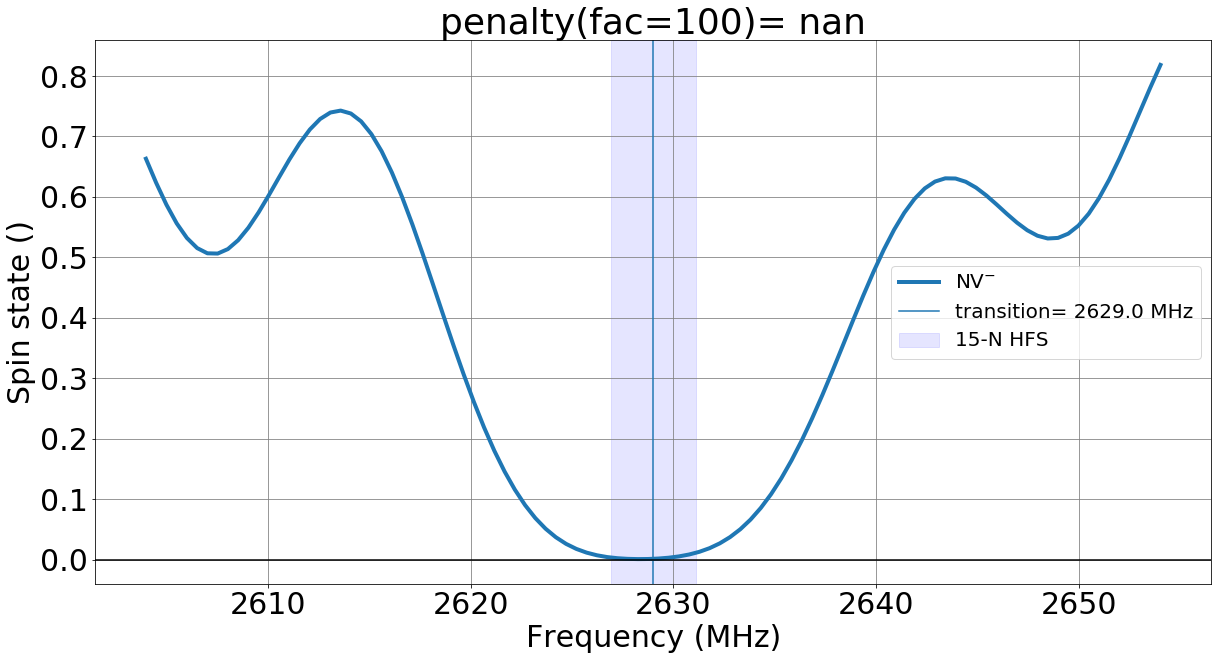

In [47]:
f_mw = simp.D - simp.gamma_nv * B

title_str = ""

# visualize the results
fig1, ax = plt.subplots(figsize=(20,10))
ax.plot(freq_array, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(freq_array+2*(B-B_nv2)/2*simp.gamma_nv, data_freq_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
#ax.plot(f_exp_mhz, y_exp, label="exp")
#ax.plot(f_exp_mhz_mirr, y_exp, label="mirrored(exp)")
#ax.set_xlim([2603,2653])

ax.axvline(f_mw, label=f"transition= {f_mw:.1f} MHz")
ax.axvspan(f_mw-2.1, f_mw+2.1, alpha=0.1, color='blue', label='15-N HFS')


# blockbands
f_lims = get_f_limits(1e6*f_mw, 1e6*f_block, 1e6*df_block, symm_block=symm_block)
for f_min, f_max in f_lims:
    f_center = (f_max + f_min) / 2
    if 1e-6*f_center > freq_array[-1] and 1e-6*f_center < freq_array[0]: 
        ax.axvline(1e-6*f_center, label=f"NV1 blockband ({1e-6*f_center:.1f} +- {df_block} MHz)", color='red')
        ax.axvspan(1e-6*f_min, 1e-6*f_max, alpha=0.1, color='red')

title_str += f"penalty(fac={fac_penalty})= {penalty:.3f}"
        
# grid
ax.axhline(0, color='black')
#ax.axhline(1, color='black')
plt.grid(axis='x', color='0.5')
plt.grid(axis='y', color='0.5')




ax.set_xlabel(r'Frequency (MHz)')
ax.set_ylabel(r'Spin state ()')
plt.title(title_str)
ax.legend(loc='best', prop={'size': 20})
plt.show(fig1)

## Amplitude Error

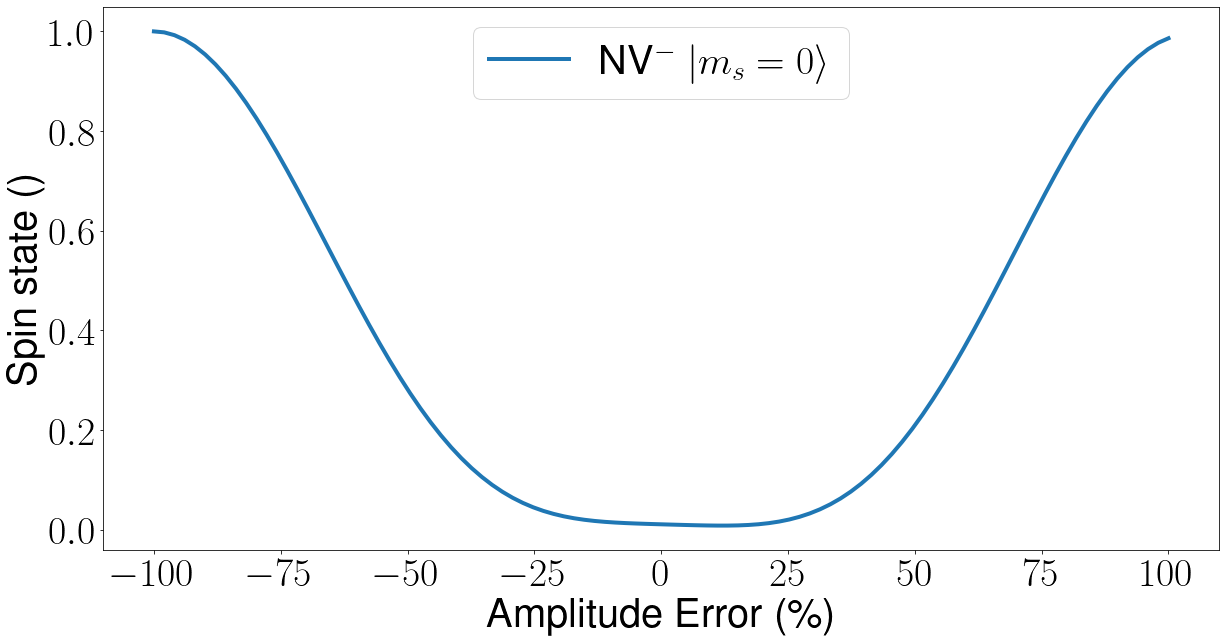

In [10]:
B= 90 #gauss

sim = TimeDependentSimulation()

# scanned amplitude steps
amp_array = np.linspace(-1, 1, 100)
data_amp_detuning = sim.run_sim_ampsweep(amp_array, pulse, B, simp)

# visualize the results
fig2, ax = plt.subplots(figsize=(20,10))
ax.plot(amp_array*100, data_amp_detuning, lw=4, label=r'NV${}^{-}~|m_s=0\rangle$')
ax.set_xlabel(r'Amplitude Error (\%)')
ax.set_ylabel(r'Spin state ()')
ax.legend(loc='best')
plt.show(fig2) 